<a href="https://colab.research.google.com/github/sushmit86/Statiistical_rethinking_jax/blob/main/sushmit_07__Ulysses_Compass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
  !pip install jaxopt
  !pip install networkx
  !pip install arviz
  !pip install causalgraphicalmodels
  !pip install daft-pgm
except:
  pass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 2.9 MB/s eta 0:00:00


In [2]:
#@title import library
import numpy as np
import scipy.stats as stats
import pandas as pd
import daft
import networkx as nx
import statsmodels.formula.api as smf
import jax
import io
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp_jax
from collections import OrderedDict
tfd = tfp_jax.distributions
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import jaxopt
from jaxopt import ScipyMinimize
import arviz
import itertools
import collections
import arviz as az
key = jax.random.PRNGKey(42)

def marginal_test_results(model, results, nll,credib_interval = 0.89, num_of_samples = 10000):
  '''
  model: tfp model like
  results: results from optimizing
  nll: negative log likelihood function
  credib_interval: the interval we are interested in
  num_of_samples: number of samples we want to get from the posterior distribution
  '''
  key = jax.random.PRNGKey(42)
  inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
  mean_list = results.params
  sd_list = jnp.diagonal(inv_hessian_matrix)**(1/2)
  low_credib_interval = (1 - credib_interval)/2
  high_credib_interval = 1 - low_credib_interval
  parameter_list = []
  normal_dist = tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list)
  for _parameter in model.parameters['model']:
    if isinstance(model.parameters['model'][_parameter],tfp_jax.distributions.Distribution):
      try:
        _shape = model.parameters['model'][_parameter].event_shape[0]
        parameter_list.extend([_parameter + '_' +str(i) for i in range(0, _shape)])
      except:
        parameter_list.append(_parameter)

  df_result = pd.DataFrame({'mean': mean_list,
                           'sd':sd_list,
                            'low': normal_dist.quantile(low_credib_interval),
                            'high':tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list).quantile(high_credib_interval) },
                           index = parameter_list)
  post_dist = tfp_jax.distributions.MultivariateNormalFullCovariance(
    loc=results.params,covariance_matrix=inv_hessian_matrix )
  post_samples = post_dist.sample( sample_shape=num_of_samples,seed=key)
  df_post_samples = pd.DataFrame(post_samples,columns = parameter_list)
  return df_result,inv_hessian_matrix,df_post_samples
credib_interval = 0.89

In [3]:
#@title 7.1
sppnames = ["afarensis","africanus","habilis","boisei", "rudolfensis","ergaster","sapiens"]
brainvolcc = [438 , 452 , 612, 521, 752, 871, 1350]
masskg = [37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5]
d = pd.DataFrame({'species': sppnames, 'brain': brainvolcc, 'mass': masskg})
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


In [4]:
#@title 7.2
d['mass_std'] = (d.mass - np.mean(d.mass))/np.std(d.mass,ddof=1)
d['brain_std'] = d.brain/np.max(d.brain)
display(d)
brain_arr =jnp.array(d.brain_std)
mass_arr = jnp.array(d.mass_std)

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


In [5]:
#@title creating the updated mass array
mass_arr_updated = jnp.linspace(mass_arr.min(),mass_arr.max(),100)

In [6]:
#@title 7.3
model7_1 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc = 0.5, scale = 1.0),
    beta = tfd.Normal(loc = 0.0, scale = 10.0),
    sigma = tfd.Normal(loc = 0.0, scale = 1.0),
    mu = lambda alpha,beta : tfd.Deterministic(alpha + beta*mass_arr),
    brain = lambda mu,sigma : tfd.Normal(loc = mu, scale = jnp.exp(sigma))
))
def nll7_1(parameters):
  samples = model7_1.sample(
      brain = brain_arr,
      alpha = parameters[0],
      beta = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1*model7_1.log_prob(samples)
optimize_fn = ScipyMinimize(fun = nll7_1, method = 'L-BFGS-B')
alpha_start = model7_1.parameters['model']['alpha'].mean()
beta_start = model7_1.parameters['model']['beta'].mean()
sigma_start = model7_1.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params = jnp.array([alpha_start,beta_start,sigma_start]))
df_result,cov_matrix, df_post_samples_m_7_1 = marginal_test_results(model7_1,results,nll7_1)
df_result.round(2)

,mean,sd,low,high
alpha,0.53,0.07,0.42,0.64
beta,0.17,0.07,0.05,0.29
sigma,-1.71,0.29,-2.18,-1.24


In [7]:
#@title 7.5
def get_r2(fn_mu,post_samples_array , mass_arr=mass_arr):
  sampled_mu = jax.vmap(fn_mu,in_axes=(None,0),out_axes=1)(post_samples_array,mass_arr)
  residual = sampled_mu.mean(axis=0) - brain_arr
  r2 = 1 - np.var(residual)/np.var(brain_arr)
  return np.array(r2)

post_samples_array = df_post_samples_m_7_1.to_numpy()
fn_mu = lambda _samples,_mass_arr : _samples[:,0] + _samples[:,1] * (_mass_arr)
r2_pow1 = get_r2(fn_mu,post_samples_array)
print('R2 for model7_1',r2_pow1)
dict_for_graphs = {"model7_1":{'R2':get_r2(fn_mu,post_samples_array)}}
# first we create the model
# array
get_mu_lower = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_1.alpha +
                                            df_post_samples_m_7_1.beta * _mass),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_1.alpha +
                                            df_post_samples_m_7_1.beta * _mass),hdi_prob = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_higher = np.vectorize(get_mu_upper)
mu_lower=vfunc_lower(mass_arr)
mu_higher=vfunc_higher(mass_arr)
mu_lower=vfunc_lower(mass_arr_updated)
mu_higher=vfunc_higher(mass_arr_updated)
# mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta','mean'] * mass_arr
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta','mean'] * mass_arr_updated
# mu_lower=vfunc_lower(mass_arr_updated)
# mu_higher=vfunc_higher(mass_arr_updated)
# mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta','mean'] * mass_arr_updated
dict_for_graphs["model7_1"]['mu_lower'] = mu_lower
dict_for_graphs["model7_1"]['mu_higher'] = mu_higher
dict_for_graphs["model7_1"]['mean_mu_pred'] = mean_mu_pred
dict_for_graphs["model7_1"]['mu_lower_non_std'] = mu_lower * np.max(d.brain)
dict_for_graphs["model7_1"]['mu_higher_non_std'] = mu_higher * np.max(d.brain)
dict_for_graphs["model7_1"]['mean_mu_pred_non_std'] = mean_mu_pred * np.max(d.brain)
# brain_sample_fn = lambda _mu_samples,_sigma : tfp_jax.distributions.Normal(_mu_samples,jnp.exp(_sigma)).sample(seed=key)
# brain_samples = jax.vmap(brain_sample_fn, in_axes=(1,None),out_axes=1)(sampled_mu,post_samples_array[:,2])
# samples_brain_hdi = np.apply_along_axis(arviz.hdi,axis=0,arr=np.array(brain_samples),hdi_prob=credib_interval).T

R2 for model7_1 0.49015534


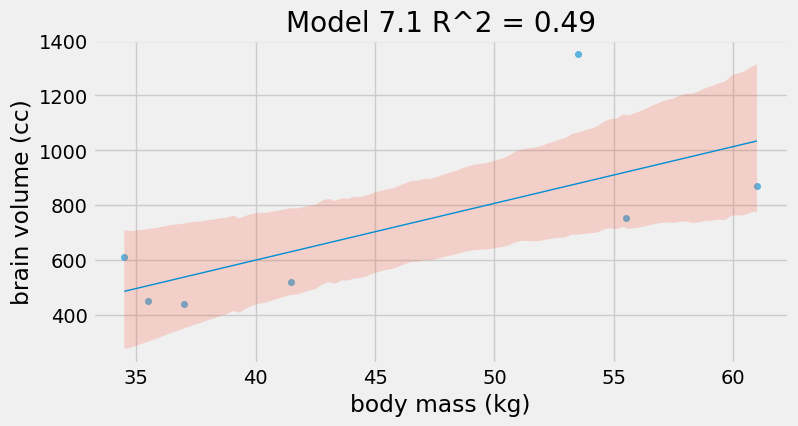

In [8]:
#@title Graph for POW1
mass_arr_updated1 = mass_arr_updated * np.std(d.mass,ddof=1) + np.mean(d.mass)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.mass, d.brain,alpha=0.6,s=20)
axs.plot(mass_arr_updated1,dict_for_graphs["model7_1"]['mean_mu_pred_non_std'],linewidth=1.0)
axs.fill_between(mass_arr_updated1,dict_for_graphs["model7_1"]['mu_lower_non_std'],
                 dict_for_graphs["model7_1"]['mu_higher_non_std'] , alpha=0.2)
axs.set_xlabel('body mass (kg)')
axs.set_ylabel('brain volume (cc)')
axs.set_title('Model 7.1 R^2 = {:.2f}'.format(r2_pow1))
fig.show()

In [9]:
#@title 7.2
d['mass_std'] = (d.mass - np.mean(d.mass))/np.std(d.mass,ddof=1)
d['brain_std'] = d.brain/np.max(d.brain)
display(d)
brain_arr =jnp.array(d.brain_std)
mass_arr = jnp.array(d.mass_std)

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


In [10]:
#@title Creating the Matrix
d['mass_std'] = (d.mass - np.mean(d.mass))/np.std(d.mass,ddof=1)
d['mass_std_2'] = d.mass_std**2
d['brain_std'] = d.brain/np.max(d.brain)
display(d)
brain_arr =jnp.array(d.brain_std)
mass_arr = jnp.array(d.mass_std)
mass_arr_2 = jnp.array(d.mass_std_2)
mass_matrix = jnp.column_stack((mass_arr,mass_arr_2))

,species,brain,mass,mass_std,brain_std,mass_std_2
0,afarensis,438,37.0,-0.779467,0.324444,0.607568
1,africanus,452,35.5,-0.917020,0.334815,0.840925
2,habilis,612,34.5,-1.008722,0.453333,1.017519
3,boisei,521,41.5,-0.366808,0.385926,0.134548
4,rudolfensis,752,55.5,0.917020,0.557037,0.840925
5,ergaster,871,61.0,1.421380,0.645185,2.020322
6,sapiens,1350,53.5,0.733616,1.000000,0.538192


In [11]:
#@title 7.7 (POW2)
model7_2 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc = 0.5, scale = 1.0),
    sigma = tfd.Normal(loc = 0.0, scale = 1.0),
    beta = tfd.Sample(tfd.Normal(loc = 0.0, scale = 10.0),sample_shape =2),
    mu = lambda alpha,beta : tfd.Deterministic(alpha + jnp.matmul(mass_matrix,beta)),
    brain = lambda mu,sigma : tfd.Normal(loc = mu, scale = jnp.exp(sigma))
))
def nll7_2(parameters):
  samples = model7_2.sample(
      brain = brain_arr,
      alpha = parameters[0],
      sigma = parameters[1],
      beta = parameters[2:],
      seed = jax.random.PRNGKey(42))
  return -1*model7_2.log_prob(samples)
optimize_fn = ScipyMinimize(fun = nll7_2, method = 'L-BFGS-B')
alpha_start = model7_2.parameters['model']['alpha'].mean()
beta_start = jnp.zeros(2)
sigma_start = model7_2.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params = jnp.concatenate((jnp.append(jnp.array(alpha_start),jnp.array(sigma_start)),
                 beta_start)))
df_result,cov_matrix, df_post_samples_m_7_2 = marginal_test_results(model7_2,results,nll7_2)
df_result.round(2)

,mean,sd,low,high
alpha,0.61,0.13,0.40,0.83
sigma,-1.75,0.29,-2.22,-1.28
beta_0,0.20,0.08,0.07,0.32
beta_1,-0.10,0.14,-0.32,0.12


In [12]:
post_samples_array = df_post_samples_m_7_2.to_numpy()
fn_mu = lambda _samples,_mass_arr : _samples[:,0] + _samples[:,2] * (_mass_arr) + _samples[:,3] * (_mass_arr)**2
print('R2 for model7_2',get_r2(fn_mu,post_samples_array))
r2_pow2 = get_r2(fn_mu,post_samples_array)
dict_for_graphs["model7_2"]={'R2':r2_pow2}

get_mu_lower = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_2.alpha + df_post_samples_m_7_2.beta_0 * _mass
                                      + df_post_samples_m_7_2.beta_1 * _mass**2),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_2.alpha + df_post_samples_m_7_2.beta_0 * _mass
                                      + df_post_samples_m_7_2.beta_1 * _mass**2),hdi = credib_interval)[1]

vfunc_lower = np.vectorize(get_mu_lower)
vfunc_higher = np.vectorize(get_mu_upper)
# mu_lower=vfunc_lower(mass_arr)
# mu_higher=vfunc_higher(mass_arr)
# mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr + df_result.loc['beta_1','mean'] * mass_arr**2
mu_lower=vfunc_lower(mass_arr_updated)
mu_higher=vfunc_higher(mass_arr_updated)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr_updated + df_result.loc['beta_1','mean'] * mass_arr_updated**2

dict_for_graphs["model7_2"]['mu_lower'] = mu_lower
dict_for_graphs["model7_2"]['mu_higher'] = mu_higher
dict_for_graphs["model7_2"]['mean_mu_pred'] = mean_mu_pred
dict_for_graphs["model7_2"]['mu_lower_non_std'] = mu_lower * np.max(d.brain)
dict_for_graphs["model7_2"]['mu_higher_non_std'] = mu_higher * np.max(d.brain)
dict_for_graphs["model7_2"]['mean_mu_pred_non_std'] = mean_mu_pred * np.max(d.brain)

R2 for model7_2 0.5359913


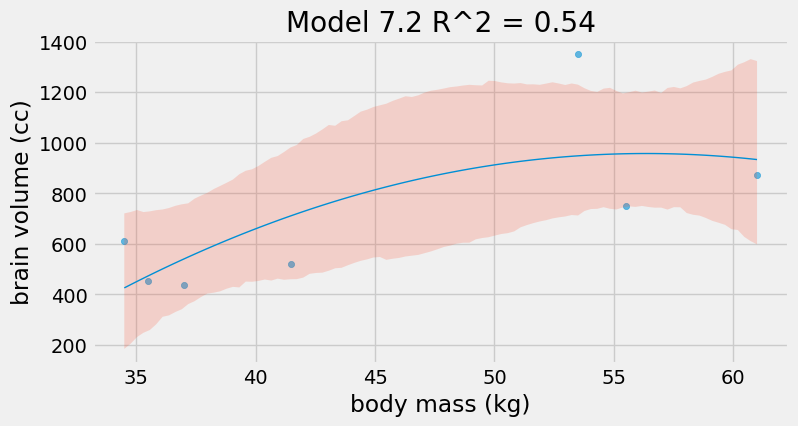

In [13]:
#@title Graph for POW2
mass_arr_updated1 = mass_arr_updated * np.std(d.mass,ddof=1) + np.mean(d.mass)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.mass, d.brain,alpha=0.6,s=20)
axs.plot(mass_arr_updated1,dict_for_graphs["model7_2"]['mean_mu_pred_non_std'],linewidth=1.0)
axs.fill_between(mass_arr_updated1,dict_for_graphs["model7_2"]['mu_lower_non_std'],
                 dict_for_graphs["model7_2"]['mu_higher_non_std'] , alpha=0.2)
axs.set_xlabel('body mass (kg)')
axs.set_ylabel('brain volume (cc)')
axs.set_title('Model 7.2 R^2 = {:.2f}'.format(r2_pow2))
fig.show()

In [14]:
#@title creating the power matrix
d['mass_std'] = (d.mass - np.mean(d.mass))/np.std(d.mass,ddof=1)
d['mass_std_2'] = d.mass_std**2
d['mass_std_3'] = d.mass_std**3
d['mass_std_4'] = d.mass_std**4
d['mass_std_5'] = d.mass_std**5
d['mass_std_6'] = d.mass_std**6
d['brain_std'] = d.brain/np.max(d.brain)
display(d)
brain_arr =jnp.array(d.brain_std)
mass_arr = jnp.array(d.mass_std)
mass_arr_2 = jnp.array(d.mass_std_2)
mass_arr_3 = jnp.array(d.mass_std**3)
mass_arr_4 = jnp.array(d.mass_std**4)
mass_arr_5 = jnp.array(d.mass_std**5)
mass_arr_6 = jnp.array(d.mass_std**6)

,species,brain,mass,mass_std,brain_std,mass_std_2,mass_std_3,mass_std_4,mass_std_5,mass_std_6
0,afarensis,438,37.0,-0.779467,0.324444,0.607568,-0.473579,0.369139,-0.287732,0.224277
1,africanus,452,35.5,-0.917020,0.334815,0.840925,-0.771145,0.707155,-0.648475,0.594664
2,habilis,612,34.5,-1.008722,0.453333,1.017519,-1.026394,1.035345,-1.044375,1.053484
3,boisei,521,41.5,-0.366808,0.385926,0.134548,-0.049353,0.018103,-0.006640,0.002436
4,rudolfensis,752,55.5,0.917020,0.557037,0.840925,0.771145,0.707155,0.648475,0.594664
5,ergaster,871,61.0,1.421380,0.645185,2.020322,2.871647,4.081702,5.801652,8.246355
6,sapiens,1350,53.5,0.733616,1.000000,0.538192,0.394826,0.289651,0.212492,0.155888


In [15]:
#@title 7.8 (POW3)
mass_matrix = jnp.column_stack((mass_arr,mass_arr_2,mass_arr_3))
model7_3 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc = 0.5, scale = 1.0),
    sigma = tfd.Normal(loc = 0.0, scale = 1.0),
    beta = tfd.Sample(tfd.Normal(loc = 0.0, scale = 10.0),sample_shape =3),
    mu = lambda alpha,beta : tfd.Deterministic(alpha + jnp.matmul(mass_matrix,beta)),
    brain = lambda mu,sigma : tfd.Normal(loc = mu, scale = jnp.exp(sigma))
))
def nll7_3(parameters):
  samples = model7_3.sample(
      brain = brain_arr,
      alpha = parameters[0],
      sigma = parameters[1],
      beta = parameters[2:],
      seed = jax.random.PRNGKey(42))
  return -1*model7_3.log_prob(samples)
optimize_fn = ScipyMinimize(fun = nll7_3, method = 'L-BFGS-B')
alpha_start = model7_3.parameters['model']['alpha'].mean()
sigma_start = model7_3.parameters['model']['sigma'].mean()
beta_start = jnp.zeros(3)
results = optimize_fn.run(init_params = jnp.concatenate((jnp.append(jnp.array(alpha_start),jnp.array(sigma_start)),
                 beta_start)))
df_result,cov_matrix, df_post_samples_m_7_3 = marginal_test_results(model7_3,results,nll7_3)
post_samples_array = df_post_samples_m_7_3.to_numpy()
fn_mu = lambda _samples,_mass_arr : _samples[:,0] + _samples[:,2] * (_mass_arr) + _samples[:,3] * (_mass_arr)**2 + _samples[:,4] * (_mass_arr)**3
print('R2 for model7_3',get_r2(fn_mu,post_samples_array))
dict_for_graphs["model7_3"]={'R2':get_r2(fn_mu,post_samples_array)}
get_mu_lower = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3.alpha + df_post_samples_m_7_3.beta_0 * _mass
                                      + df_post_samples_m_7_3.beta_1 * _mass**2 + df_post_samples_m_7_3.beta_2 * _mass**3),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3.alpha + df_post_samples_m_7_3.beta_0 * _mass +
                                                df_post_samples_m_7_3.beta_1 * _mass**2 + df_post_samples_m_7_3.beta_2 * _mass**3),hdi = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_higher = np.vectorize(get_mu_upper)
# mu_lower=vfunc_lower(mass_arr)
# mu_higher=vfunc_higher(mass_arr)
# mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr + df_result.loc['beta_1','mean'] * mass_arr**2 + df_result.loc['beta_2','mean'] * mass_arr**3

mu_lower = vfunc_lower(mass_arr_updated)
mu_higher = vfunc_higher(mass_arr_updated)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr_updated + df_result.loc['beta_1','mean'] * mass_arr_updated**2 + df_result.loc['beta_2','mean'] * mass_arr_updated**3
dict_for_graphs["model7_3"]['mu_lower'] = mu_lower
dict_for_graphs["model7_3"]['mu_higher'] = mu_higher
dict_for_graphs["model7_3"]['mean_mu_pred'] = mean_mu_pred
dict_for_graphs["model7_3"]['mu_lower_non_std'] = mu_lower * np.max(d.brain)
dict_for_graphs["model7_3"]['mu_higher_non_std'] = mu_higher * np.max(d.brain)
dict_for_graphs["model7_3"]['mean_mu_pred_non_std'] = mean_mu_pred * np.max(d.brain)

R2 for model7_3 0.67975557


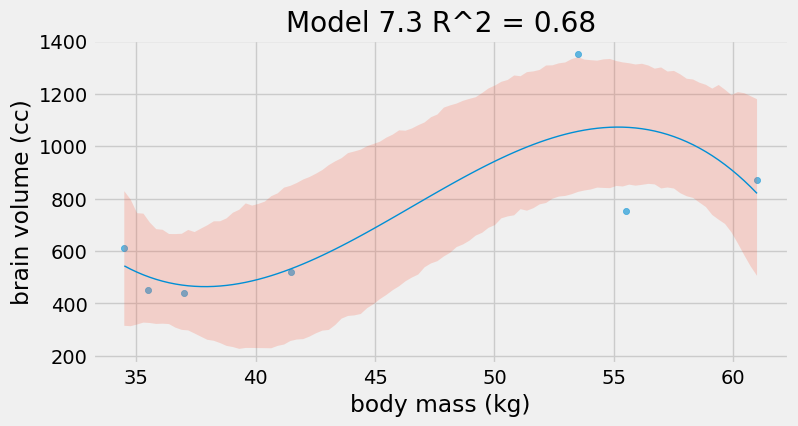

In [16]:
#@title Graph for POW3
mass_arr_updated1 = mass_arr_updated * np.std(d.mass,ddof=1) + np.mean(d.mass)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.mass, d.brain,alpha=0.6,s=20)
axs.plot(mass_arr_updated1,dict_for_graphs["model7_3"]['mean_mu_pred_non_std'],linewidth=1.0)
axs.fill_between(mass_arr_updated1,dict_for_graphs["model7_3"]['mu_lower_non_std'],
                 dict_for_graphs["model7_3"]['mu_higher_non_std'] , alpha=0.2)
axs.set_xlabel('body mass (kg)')
axs.set_ylabel('brain volume (cc)')
axs.set_title('Model 7.3 R^2 = {:.2f}'.format(dict_for_graphs["model7_3"]["R2"]))
fig.show()

In [17]:
#@title 7.8 (POW4)
mass_matrix = jnp.column_stack((mass_arr,mass_arr_2,mass_arr_3,mass_arr_4))
model7_3_pow4 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc = 0.5, scale = 1.0),
    sigma = tfd.Normal(loc =0.0,scale = 1.0),
    beta = tfd.Sample(tfd.Normal(loc = 0.0, scale = 10.0),sample_shape = 4),
        mu = lambda alpha,beta : tfd.Deterministic(alpha + jnp.matmul(mass_matrix,beta)),
    brain = lambda mu,sigma : tfd.Normal(loc = mu, scale = jnp.exp(sigma))
))
def nll7_3_pow4(parameters):
  samples = model7_3_pow4.sample(
      brain = brain_arr,
      alpha = parameters[0],
      sigma = parameters[1],
      beta = parameters[2:],
      seed = jax.random.PRNGKey(42))
  return -1*model7_3_pow4.log_prob(samples)
optimize_fn = ScipyMinimize(fun = nll7_3_pow4, method = 'L-BFGS-B')
alpha_start = model7_3_pow4.parameters['model']['alpha'].mean()
sigma_start = model7_3_pow4.parameters['model']['sigma'].mean()
beta_start = jnp.zeros(4)
results = optimize_fn.run(init_params = jnp.concatenate((jnp.append(jnp.array(alpha_start),jnp.array(sigma_start)),
                 beta_start)))
df_result,cov_matrix, df_post_samples_m_7_3_pow4 = marginal_test_results(model7_3_pow4,results,nll7_3_pow4)
df_result.round(2)

post_samples_array = df_post_samples_m_7_3_pow4.to_numpy()
fn_mu = lambda _samples,_mass_arr : _samples[:,0] + _samples[:,2] * (_mass_arr) + _samples[:,3] * (_mass_arr)**2 + _samples[:,4] * (_mass_arr)**3 + _samples[:,5] * (_mass_arr)**4
print('R2 for model7_3_pow4',get_r2(fn_mu,post_samples_array))
dict_for_graphs["model7_3_pow4"]={'R2':get_r2(fn_mu,post_samples_array)}
get_mu_lower = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3_pow4.alpha + df_post_samples_m_7_3_pow4.beta_0 * _mass
                                      + df_post_samples_m_7_3_pow4.beta_1 * _mass**2 + df_post_samples_m_7_3_pow4.beta_2 * _mass**3 +
                                                df_post_samples_m_7_3_pow4.beta_3 * _mass**4),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3_pow4.alpha + df_post_samples_m_7_3_pow4.beta_0 * _mass
                                                + df_post_samples_m_7_3_pow4.beta_1 * _mass**2 + df_post_samples_m_7_3_pow4.beta_2 * _mass**3
                                                + df_post_samples_m_7_3_pow4.beta_3 * _mass**4),hdi = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_higher = np.vectorize(get_mu_upper)
# mu_lower=vfunc_lower(mass_arr)
# mu_higher=vfunc_higher(mass_arr)
# mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr + df_result.loc['beta_1','mean'] * mass_arr**2 + df_result.loc['beta_2','mean'] * mass_arr**3 + df_result.loc['beta_3','mean'] * mass_arr**4

mu_lower=vfunc_lower(mass_arr_updated)
mu_higher=vfunc_higher(mass_arr_updated)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr_updated + df_result.loc['beta_1','mean'] * mass_arr_updated**2 + df_result.loc['beta_2','mean'] * mass_arr_updated**3 + df_result.loc['beta_3','mean'] * mass_arr_updated**4
dict_for_graphs["model7_3_pow4"]['mu_lower'] = mu_lower
dict_for_graphs["model7_3_pow4"]['mu_higher'] = mu_higher
dict_for_graphs["model7_3_pow4"]['mean_mu_pred'] = mean_mu_pred
dict_for_graphs["model7_3_pow4"]['mu_lower_non_std'] = mu_lower * np.max(d.brain)
dict_for_graphs["model7_3_pow4"]['mu_higher_non_std'] = mu_higher * np.max(d.brain)
dict_for_graphs["model7_3_pow4"]['mean_mu_pred_non_std'] = mean_mu_pred * np.max(d.brain)

R2 for model7_3_pow4 0.81423944


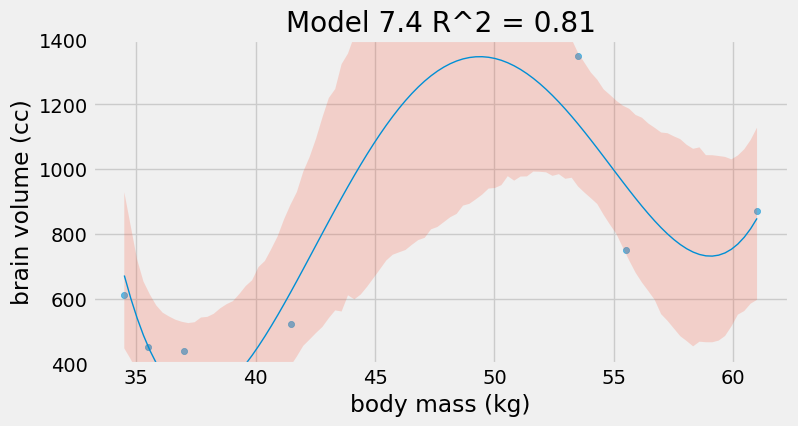

In [18]:
#@title Graph for POW4
mass_arr_updated1 = mass_arr_updated * np.std(d.mass,ddof=1) + np.mean(d.mass)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.mass, d.brain,alpha=0.6,s=20)
axs.plot(mass_arr_updated1,dict_for_graphs["model7_3_pow4"]['mean_mu_pred_non_std'],linewidth=1.0)
axs.fill_between(mass_arr_updated1,dict_for_graphs["model7_3_pow4"]['mu_lower_non_std'],
                 dict_for_graphs["model7_3_pow4"]['mu_higher_non_std'] , alpha=0.2)
axs.set_xlabel('body mass (kg)')
axs.set_ylabel('brain volume (cc)')
axs.set_title('Model 7.4 R^2 = {:.2f}'.format(dict_for_graphs["model7_3_pow4"]["R2"]))
axs.set_ylim(400,1400)
fig.show()

In [19]:
#@title 7.8 (pow5)
mass_matrix = jnp.column_stack((mass_arr,mass_arr_2,mass_arr_3,mass_arr_4,mass_arr_5))
model7_3_pow5 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc = 0.5, scale = 1.0),
    sigma = tfd.Normal(loc =0.0,scale = 1.0),
    beta = tfd.Sample(tfd.Normal(loc = 0.0, scale = 10.0),sample_shape = 5),
    mu = lambda alpha,beta : tfd.Deterministic(alpha + jnp.matmul(mass_matrix,beta)),
    brain = lambda mu,sigma : tfd.Normal(loc = mu, scale = jnp.exp(sigma))
))
def nll7_3_pow5(parameters):
  samples = model7_3_pow5.sample(
      brain = brain_arr,
      alpha = parameters[0],
      sigma = parameters[1],
      beta = parameters[2:],
      seed = jax.random.PRNGKey(42))
  return -1*model7_3_pow5.log_prob(samples)
optimize_fn = ScipyMinimize(fun = nll7_3_pow5, method = 'L-BFGS-B')
alpha_start = model7_3_pow5.parameters['model']['alpha'].mean()
sigma_start = model7_3_pow5.parameters['model']['sigma'].mean()
beta_start = jnp.zeros(5)
results = optimize_fn.run(init_params = jnp.concatenate((jnp.append(jnp.array(alpha_start),jnp.array(sigma_start)),
                 beta_start)))
df_result,cov_matrix, df_post_samples_m_7_3_pow5 = marginal_test_results(model7_3_pow5,results,nll7_3_pow5)
df_result.round(2)
post_samples_array = df_post_samples_m_7_3_pow5.to_numpy()
fn_mu = lambda _samples,_mass_arr : _samples[:,0] + _samples[:,2] * (_mass_arr) + _samples[:,3] * (_mass_arr)**2 + _samples[:,4] * (_mass_arr)**3 + _samples[:,5]* (_mass_arr)**4 + _samples[:,6] * (_mass_arr)**5
print('R2 for model7_3_pow5',get_r2(fn_mu,post_samples_array))
dict_for_graphs["model7_3_pow5"]={'R2':get_r2(fn_mu,post_samples_array)}
get_mu_lower = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3_pow5.alpha + df_post_samples_m_7_3_pow5.beta_0 * _mass
                                                + df_post_samples_m_7_3_pow5.beta_1 * _mass**2 + df_post_samples_m_7_3_pow5.beta_2 * _mass**3
                                                + df_post_samples_m_7_3_pow5.beta_3 * _mass**4 + df_post_samples_m_7_3_pow5.beta_4 * _mass**5
),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3_pow5.alpha + df_post_samples_m_7_3_pow5.beta_0 * _mass
                                                + df_post_samples_m_7_3_pow5.beta_1 * _mass**2 + df_post_samples_m_7_3_pow5.beta_2 * _mass**3
                                                + df_post_samples_m_7_3_pow5.beta_3 * _mass**4 + df_post_samples_m_7_3_pow5.beta_4 * _mass**5
),hdi = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_higher = np.vectorize(get_mu_upper)
# mu_lower=vfunc_lower(mass_arr)
# mu_higher=vfunc_higher(mass_arr)
# mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr + df_result.loc['beta_1','mean'] * mass_arr**2 + df_result.loc['beta_2','mean'] * mass_arr**3 + df_result.loc['beta_3','mean'] * mass_arr**4 + df_result.loc['beta_4','mean'] * mass_arr**5
mu_lower=vfunc_lower(mass_arr_updated)
mu_higher=vfunc_higher(mass_arr_updated)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr_updated + df_result.loc['beta_1','mean'] * mass_arr_updated**2 + df_result.loc['beta_2','mean'] * mass_arr_updated**3 + df_result.loc['beta_3','mean'] * mass_arr_updated**4 + df_result.loc['beta_4','mean'] * mass_arr_updated**5
dict_for_graphs["model7_3_pow5"]['mu_lower'] = mu_lower
dict_for_graphs["model7_3_pow5"]['mu_higher'] = mu_higher
dict_for_graphs["model7_3_pow5"]['mean_mu_pred'] = mean_mu_pred
dict_for_graphs['model7_3_pow5']['mu_lower_non_std'] = mu_lower * np.max(d.brain)
dict_for_graphs['model7_3_pow5']['mu_higher_non_std'] = mu_higher * np.max(d.brain)
dict_for_graphs['model7_3_pow5']['mean_mu_pred_non_std'] = mean_mu_pred * np.max(d.brain)


R2 for model7_3_pow5 0.98885006


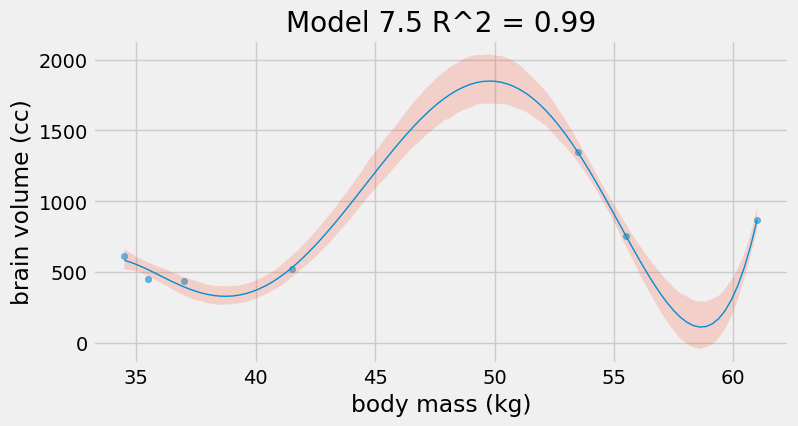

In [20]:
#@title Graph for POW4
mass_arr_updated1 = mass_arr_updated * np.std(d.mass,ddof=1) + np.mean(d.mass)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.mass, d.brain,alpha=0.6,s=20)
axs.plot(mass_arr_updated1,dict_for_graphs["model7_3_pow5"]['mean_mu_pred_non_std'],linewidth=1.0)
axs.fill_between(mass_arr_updated1,dict_for_graphs["model7_3_pow5"]['mu_lower_non_std'],
                 dict_for_graphs["model7_3_pow5"]['mu_higher_non_std'] , alpha=0.2)
axs.set_xlabel('body mass (kg)')
axs.set_ylabel('brain volume (cc)')
axs.set_title('Model 7.5 R^2 = {:.2f}'.format(dict_for_graphs["model7_3_pow5"]["R2"]))

fig.show()

In [21]:
#@title 7.8 (pow6)
mass_matrix = jnp.column_stack((mass_arr,mass_arr_2,mass_arr_3,mass_arr_4,mass_arr_5,mass_arr_6))
model7_3_pow6 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc = 0.5, scale = 1.0),
    beta = tfd.Sample(tfd.Normal(loc = 0.0, scale = 10.0),sample_shape = 6),
    mu = lambda alpha,beta : tfd.Deterministic(alpha + jnp.matmul(mass_matrix,beta)),
    brain = lambda mu : tfd.Normal(loc = mu, scale = 0.001)
))
def nll7_3_pow6(parameters):
  samples = model7_3_pow6.sample(
      brain = brain_arr,
      alpha = parameters[0],
      beta = parameters[1:],
      seed = jax.random.PRNGKey(42))
  return -1*model7_3_pow6.log_prob(samples)

optimize_fn = ScipyMinimize(fun = nll7_3_pow6, method = 'L-BFGS-B')
alpha_start = model7_3_pow6.parameters['model']['alpha'].mean()
beta_start = jnp.zeros(6)
results = optimize_fn.run(init_params = jnp.append(jnp.array(alpha_start),jnp.zeros(6)))
df_result,cov_matrix, df_post_samples_m_7_3_pow6 = marginal_test_results(model7_3_pow6,results,nll7_3_pow6)
df_result.round(2)
post_samples_array = df_post_samples_m_7_3_pow6.to_numpy()
fn_mu = lambda _samples,_mass_arr : _samples[:,0] + _samples[:,1] * (_mass_arr) + _samples[:,2] * (_mass_arr)**2 + _samples[:,3] * (_mass_arr)**3 + _samples[:,4]* (_mass_arr)**4 + _samples[:,5] * (_mass_arr)**5 + _samples[:,6] * (_mass_arr)**6
# fn_mu_concise = lambda _samples, _mass_arr: np.polyval(_samples[:, ::-1], _mass_arr)
print('R2 for model7_3_pow6',get_r2(fn_mu,post_samples_array))
dict_for_graphs["model7_3_pow6"]={'R2':get_r2(fn_mu,post_samples_array)}
get_mu_lower = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3_pow6.alpha + df_post_samples_m_7_3_pow6.beta_0 * _mass + df_post_samples_m_7_3_pow6.beta_1 * _mass**2 +
                                                df_post_samples_m_7_3_pow6.beta_2 * _mass**3 + df_post_samples_m_7_3_pow6.beta_3 * _mass**4 +
                                                df_post_samples_m_7_3_pow6.beta_4 * _mass**5 + df_post_samples_m_7_3_pow6.beta_5 * _mass**6),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _mass: arviz.hdi(np.array(df_post_samples_m_7_3_pow6.alpha  + df_post_samples_m_7_3_pow6.beta_0
                                                * _mass + df_post_samples_m_7_3_pow6.beta_1 * _mass**2 + df_post_samples_m_7_3_pow6.beta_2 * _mass**3 +
                                                df_post_samples_m_7_3_pow6.beta_3 * _mass**4 + df_post_samples_m_7_3_pow6.beta_4 * _mass**5 +
                                                df_post_samples_m_7_3_pow6.beta_5 * _mass**6),hdi = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_higher = np.vectorize(get_mu_upper)
# mu_lower=vfunc_lower(mass_arr)
# mu_higher=vfunc_higher(mass_arr)
# mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr + df_result.loc['beta_1','mean'] * mass_arr**2 + df_result.loc['beta_2','mean'] * mass_arr**3 + df_result.loc['beta_3','mean'] * mass_arr**4 + df_result.loc['beta_4','mean'] * mass_arr**5 + df_result.loc['beta_5','mean'] * mass_arr**6
mu_lower=vfunc_lower(mass_arr_updated)
mu_higher=vfunc_higher(mass_arr_updated)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta_0','mean'] * mass_arr_updated + df_result.loc['beta_1','mean'] * mass_arr_updated**2 + df_result.loc['beta_2','mean'] * mass_arr_updated**3 + df_result.loc['beta_3','mean'] * mass_arr_updated**4 + df_result.loc['beta_4','mean'] * mass_arr_updated**5 + df_result.loc['beta_5','mean'] * mass_arr_updated**6
dict_for_graphs["model7_3_pow6"]['mu_lower'] = mu_lower
dict_for_graphs["model7_3_pow6"]['mu_higher'] = mu_higher
dict_for_graphs["model7_3_pow6"]['mean_mu_pred'] = mean_mu_pred
dict_for_graphs["model7_3_pow6"]['mu_lower_non_std'] = mu_lower * np.max(d.brain)
dict_for_graphs["model7_3_pow6"]['mu_higher_non_std'] = mu_higher * np.max(d.brain)
dict_for_graphs["model7_3_pow6"]['mean_mu_pred_non_std'] = mean_mu_pred * np.max(d.brain)

R2 for model7_3_pow6 1.0


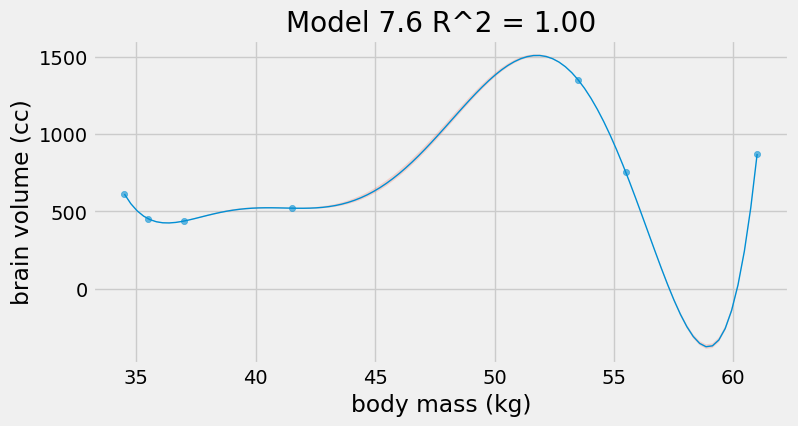

In [22]:
#@title Graph for POW4
mass_arr_updated1 = mass_arr_updated * np.std(d.mass,ddof=1) + np.mean(d.mass)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.mass, d.brain,alpha=0.6,s=20)
axs.plot(mass_arr_updated1,dict_for_graphs["model7_3_pow6"]['mean_mu_pred_non_std'],linewidth=1.0)
axs.fill_between(mass_arr_updated1,dict_for_graphs["model7_3_pow6"]['mu_lower_non_std'],
                 dict_for_graphs["model7_3_pow6"]['mu_higher_non_std'] , alpha=0.2)
axs.set_xlabel('body mass (kg)')
axs.set_ylabel('brain volume (cc)')
axs.set_title('Model 7.6 R^2 = {:.2f}'.format(dict_for_graphs["model7_3_pow6"]["R2"]))

fig.show()

# Exploring log_sum_exp

In [23]:
#@title overlfow example
x_array = [1000,1000,1000]
np.exp(x_array) ## overflow encountered

def log_sum_exp(x_array):
  max_element = np.max(x_array)
  return max_element + np.log(np.sum(np.exp(x_array - max_element)))
print(log_sum_exp(x_array))
prob_array = np.exp(x_array-log_sum_exp(x_array))
prob_array

1001.0986122886682


<ipython-input-23-71b2ec09be41>:3: RuntimeWarning: overflow encountered in exp
  np.exp(x_array) ## overflow encountered


array([0.33333333, 0.33333333, 0.33333333])

In [24]:
#@title underflow example
x_array = [-1000,-1000,-1000]
np.exp(x_array) ## underflow encountered
prob_array = np.exp(x_array-log_sum_exp(x_array))
prob_array

array([0.33333333, 0.33333333, 0.33333333])

In [25]:
#@title underflow example
x_array = [-1000,-1000,1000]
np.exp(x_array) ## underflow encountered
print(log_sum_exp(x_array))
prob_array = np.exp(x_array-log_sum_exp(x_array))
prob_array

1000.0


<ipython-input-25-48c51157f57c>:3: RuntimeWarning: overflow encountered in exp
  np.exp(x_array) ## underflow encountered


array([0., 0., 1.])

In [26]:
#@title logsumexp fomr scipy
from scipy.special import logsumexp
x_array = [1000,1000,1000]
logsumexp(x_array)
prob_array = np.exp(x_array-logsumexp(x_array))
prob_array

array([0.33333333, 0.33333333, 0.33333333])

# 7.2 Entropy and Accuracy

In [27]:
#@title 7.12
p = np.array([0.3,0.7])
np.sum(-p * np.log(p))

np.float64(0.6108643020548935)

In [38]:
df_post_samples_m_7_1.head()

,alpha,beta,sigma
0,0.526606,0.201714,-1.619833
1,0.539050,0.157921,-1.643025
2,0.429950,0.223103,-1.553054
3,0.590822,0.138625,-1.372144
4,0.627472,0.247182,-1.723753


In [40]:
d.head(n=2)

,species,brain,mass,mass_std,brain_std,mass_std_2,mass_std_3,mass_std_4,mass_std_5,mass_std_6
0,afarensis,438,37.0,-0.779467,0.324444,0.607568,-0.473579,0.369139,-0.287732,0.224277
1,africanus,452,35.5,-0.917020,0.334815,0.840925,-0.771145,0.707155,-0.648475,0.594664


In [96]:
mu_arr = df_post_samples_m_7_1['alpha'] + df_post_samples_m_7_1['beta'] * mass_arr[0]
sigma_arr = np.exp(df_post_samples_m_7_1['sigma'])
ll_test = stats.norm.logpdf(d.brain_std[0],loc = mu_arr, scale = sigma_arr)
n = len(mass_arr)
ns = df_post_samples_m_7_1.shape[0]
ll = np.zeros((ns, n))
sigma_arr = np.exp(df_post_samples_m_7_1['sigma'])
for s in range(n):
    mu_arr = df_post_samples_m_7_1['alpha'] + df_post_samples_m_7_1['beta'] * mass_arr[s]
    logprob = stats.norm.logpdf(d.brain_std[s], mu_arr, sigma_arr)
    ll[:,s] = logprob

In [97]:
ll[:,0].shape

(10000,)

In [98]:
print(ll.shape)
print(ll[:,0].shape)
print(ll_test.shape)
assert (ll[:,0] ==  ll_test).all()

(10000, 7)
(10000,)
(10000,)


In [99]:
mu_arr_1 = df_post_samples_m_7_1['alpha'].values.reshape(-1,1) + df_post_samples_m_7_1['beta'].values.reshape(-1,1)   * np.tile(mass_arr, (10000,1))

In [100]:
ll_test1 = stats.norm.logpdf(np.tile(d.brain_std, (10000,1)), mu_arr_1, sigma_arr.values.reshape(-1,1))

In [110]:
print(ll_test1.shape)
assert (ll_test1[:,0] ==  ll_test).all()

sum(logsumexp(ll_test1,axis=0) - np.log(10000))

(10000, 7)


np.float64(2.4943892220141084)